In [1]:
import pandas as pd
import codecs
import os
import numpy as np

In [2]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches

matplotlib.rcParams['text.usetex']=False
# matplotlib.rcParams['text.latex.unicode']=True

matplotlib.rcParams['figure.autolayout'] = True

sns.set_style('ticks', {'xtick.bottom': True, "ytick.left": True, 'grid.color': '0.9'})

sns.set_context(
	"talk",
	font_scale=0.9,
	rc={
		"lines.linewidth": 2,
		"text.usetex": False,
		"font.family": 'Lato',
		"font.sans-serif": ['Palatino'],
		"font.weight": 'bold',
		"font.size": 22,
		"xtick.major.size": 6,
		"xtick.major.width": 2,
		"ytick.left": True
	})

In [3]:
data_path = '../data/'

In [4]:
files = os.listdir(data_path)

In [5]:
posts = pd.read_csv(data_path + 'posts.csv')

In [6]:
len(posts[posts['annotated'] == 'Y'])

941

### Change in Belief

In [9]:
pre_belief = pd.read_csv(data_path + 'pre_belief.csv')

In [11]:
# prolific id is not None

pre_belief = pre_belief[pre_belief['prolific_id'].notnull()]

# condition is not None

pre_belief = pre_belief[pre_belief['condition'].notnull()]

In [12]:
# remove duplicate prolific id, keep the last one

pre_belief = pre_belief.drop_duplicates(subset='prolific_id', keep='last')

In [13]:
post_belief = pd.read_csv(data_path + 'post_belief.csv')

In [14]:
# prolific id is not None

post_belief = post_belief[post_belief['prolific_id'].notnull()]

# condition is not None

post_belief = post_belief[post_belief['condition'].notnull()]

In [15]:
# remove duplicate prolific id, keep the last one

post_belief = post_belief.drop_duplicates(subset='prolific_id', keep='last')

In [17]:
# join pre and post belief on prolific id, post id

pre_belief = pre_belief.rename(columns={'label': 'pre_label'})
post_belief = post_belief.rename(columns={'label': 'post_label'})

pre_post_belief = pd.merge(pre_belief, post_belief, on='prolific_id', how='inner')

In [19]:
# remove 62cf2c16297da842a4b56430 -- test user

pre_post_belief = pre_post_belief[pre_post_belief['prolific_id'] != '62cf2c16297da842a4b56430']

In [20]:
# change in label

pre_post_belief['change_in_label'] = pre_post_belief['post_label'] - pre_post_belief['pre_label']


# percentage change

pre_post_belief['percentage_change'] = (pre_post_belief['post_label'] - pre_post_belief['pre_label']) / pre_post_belief['pre_label']

In [21]:
# condition_x -- Categorical and Ordered 'label' and 'no label'

pre_post_belief['condition_x'] = pre_post_belief['condition_x'].map({'label': 'Label', 'no label': 'No Label'})

# ordered

pre_post_belief['condition_x'] = pd.Categorical(pre_post_belief['condition_x'], categories=['No Label', 'Label'], ordered=True)

In [22]:
# prebelief

# 1: Extremely Accurate
# 2: Accurate
# 3: Somewhat Accurate
# 4: Neutral
# 5: Somewhat Misleading
# 6: Misleading
# 7: Extremely Misleading

pre_post_belief['pre_label_map'] = pre_post_belief['pre_label'].map({1: '1: Extremely Accurate', 2: '2: Accurate', 3: '3: Somewhat Accurate', 4: '4: Neutral', 5: '5: Somewhat Misleading', 6: '6: Misleading', 7: '7: Extremely Misleading'})

# ordered

pre_post_belief['pre_label_map'] = pd.Categorical(pre_post_belief['pre_label_map'], categories=['1: Extremely Accurate', '2: Accurate', '3: Somewhat Accurate', '4: Neutral', '5: Somewhat Misleading', '6: Misleading', '7: Extremely Misleading'], ordered=True)

In [23]:
# post_id_x to post_id

pre_post_belief = pre_post_belief.rename(columns={'post_id_x': 'post_id'})

In [24]:
# merge with posts[['post_id', 'response_type']]

pre_post_belief = pd.merge(pre_post_belief, posts[['post_id', 'response_type']], on='post_id', how='inner')

In [25]:
pre_belief['collection_time'] = 'pre'
post_belief['collection_time'] = 'post'

pre_belief['label'] = pre_belief['pre_label']
post_belief['label'] = post_belief['post_label']

In [26]:
pre_post_belief_concat = pd.concat([pre_belief, post_belief], axis=0)

In [28]:
condition_map = {'label': 'Signaling', 'no label': 'No Signaling'}

pre_post_belief_concat['condition_map'] = pre_post_belief_concat['condition'].map(condition_map)

/tmp/ipykernel_591108/566046559.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Before Reading\nthe Response', 'After Reading\nthe Response'])


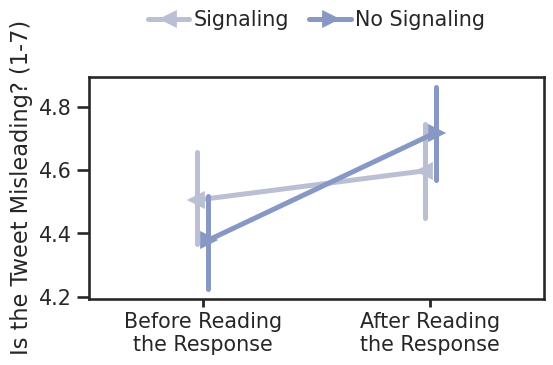

In [29]:
g = sns.pointplot(x='collection_time', y='label', hue='condition_map', data=pre_post_belief_concat, dodge=True, palette=['#BABFD4', '#8798C4'], markers=['<', '>'],)

ax = g.axes

ax.set_ylabel('Is the Tweet Misleading? (1-7)')

ax.set_xlabel('')

ax.set_xticklabels(['Before Reading\nthe Response', 'After Reading\nthe Response'])


# legend outside

# plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.legend(bbox_to_anchor=(0.5, 1.3), loc='upper center', borderaxespad=0., ncol=2, title=None, facecolor='w', edgecolor='w', framealpha=1, fancybox=False, handletextpad=0.2, borderpad=0., labelspacing=0.5, columnspacing=1.)


# increase width

plt.gcf().set_size_inches(6, 4)


In [30]:
def cohen_d(x, y):
	nx = len(x)
	ny = len(y)
	dof = nx + ny - 2
	s = ((nx - 1) * x.std() ** 2 + (ny - 1) * y.std() ** 2) / dof
	s = s ** 0.5
	d = (x.mean() - y.mean()) / s
	return d

In [31]:
# is the difference between pre_label and post_label statistically significant?

from scipy.stats import ttest_ind

# for each condition

for condition in ['label', 'no label']:
	print(condition)

	print(cohen_d(pre_post_belief_concat[(pre_post_belief_concat['condition'] == condition) & ~(pre_post_belief_concat['pre_label'].isna())]['pre_label'], pre_post_belief_concat[(pre_post_belief_concat['condition'] == condition) & ~(pre_post_belief_concat['post_label'].isna())]['post_label']))

	print(ttest_ind(pre_post_belief_concat[(pre_post_belief_concat['condition'] == condition) & ~(pre_post_belief_concat['pre_label'].isna())]['pre_label'], pre_post_belief_concat[(pre_post_belief_concat['condition'] == condition) & ~(pre_post_belief_concat['post_label'].isna())]['post_label']))

	print('pre: ', pre_post_belief_concat[pre_post_belief_concat['condition'] == condition]['pre_label'].mean())

	print('post: ', pre_post_belief_concat[pre_post_belief_concat['condition'] == condition]['post_label'].mean())


	# diff

	print('diff: ', pre_post_belief_concat[pre_post_belief_concat['condition'] == condition]['post_label'].mean() - pre_post_belief_concat[pre_post_belief_concat['condition'] == condition]['pre_label'].mean())

	# relative_diff

	print('relative_diff: ', (pre_post_belief_concat[pre_post_belief_concat['condition'] == condition]['post_label'].mean() - pre_post_belief_concat[pre_post_belief_concat['condition'] == condition]['pre_label'].mean()) / pre_post_belief_concat[pre_post_belief_concat['condition'] == condition]['pre_label'].mean())

label
-0.05425143666611441
TtestResult(statistic=-0.8646256233802613, pvalue=0.38744879603529614, df=1014.0)
pre:  4.505905511811024
post:  4.5984251968503935
diff:  0.09251968503936947
relative_diff:  0.020532983835735992
no label
-0.20134145720135396
TtestResult(statistic=-3.127279048777846, pvalue=0.0018172878837592163, df=963.0)
pre:  4.37888198757764
post:  4.719917012448133
diff:  0.341035024870493
relative_diff:  0.07788175745269414


In [32]:
pre_post_belief_concat = pd.merge(pre_post_belief_concat, posts[['post_id', 'response_type']], on='post_id', how='inner')

In [33]:
pre_post_belief_concat['response_type'] = pre_post_belief_concat['response_type'].map({'human-high': 'Laypeople (high)', 'human-avg': 'Laypeople (avg)', 'gpt-4': 'GPT-4', 'muse': 'MUSE'})

pre_post_belief_concat['response_type'] = pd.Categorical(pre_post_belief_concat['response_type'], categories=['Laypeople (avg)', 'Laypeople (high)', 'GPT-4', 'MUSE'], ordered=True)

In [34]:
method_color = {
    'Laypeople (avg)': '#F7E6CC',
    'Laypeople (high)': '#F8D3A6',
    'GPT-4': '#BABFD4',
    'MUSE': '#8798C4'
}

In [35]:
method_marker = {
    'MUSE': 's',
    'GPT-4': 'o',
    'Laypeople (high)': '>',
    'Laypeople (avg)': '<'
}


In [36]:
matplotlib.rcParams['font.size'] = 12


/tmp/ipykernel_591108/30648565.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Before Reading\nthe Response', 'After Reading\nthe Response'])


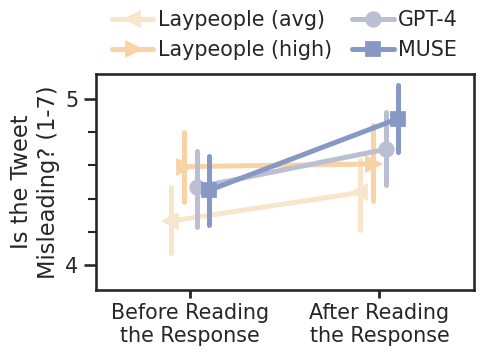

In [37]:
g = sns.pointplot(x='collection_time', y='label', hue='response_type', data=pre_post_belief_concat, dodge=0.2, palette=['#F7E6CC', '#F8D3A6', '#BABFD4', '#8798C4'], markers=['<', '>', 'o', 's'],)

ax = g.axes

ax.set_ylabel('Is the Tweet\nMisleading? (1-7)')

ax.set_xlabel('')

# change xtick labels 'before reading\nthe response', 'after reading\nthe response'

ax.set_xticklabels(['Before Reading\nthe Response', 'After Reading\nthe Response'])

ax.set_ylim([3.85, 5.15])

# y-ticks 4 to 5: 
ax.set_yticks([4, 5])

# minor ticks every 0.2, major every 1

# major every 1, minor every 0.2 

# ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.2))


# legend outside and on top 4 columns, no title, no box

plt.legend(bbox_to_anchor=(0.5, 1.3), loc='upper center', borderaxespad=0., ncol=2, title=None, facecolor='w', edgecolor='w', framealpha=1, fancybox=False, handletextpad=0.2, borderpad=0., labelspacing=0.5, columnspacing=1.)


# increase width

plt.gcf().set_size_inches(5, 4)

# tight_layout
plt.tight_layout()

# save

# plt.savefig('pre_post_belief.svg')


In [38]:
pre_post_belief['response_type'] = pre_post_belief['response_type'].map({'human-high': 'Laypeople (high)', 'human-avg': 'Laypeople (avg)', 'gpt-4': 'GPT-4', 'muse': 'MUSE'})

pre_post_belief['response_type'] = pd.Categorical(pre_post_belief['response_type'], categories=['Laypeople (avg)', 'Laypeople (high)', 'GPT-4', 'MUSE'], ordered=True)

/tmp/ipykernel_591108/3547175474.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.pointplot(y='response_type', x='change_in_label', data=pre_post_belief, dodge=True, palette=['#F7E6CC', '#F8D3A6', '#BABFD4', '#8798C4'], markers=['<', '>', 'o', 's'])


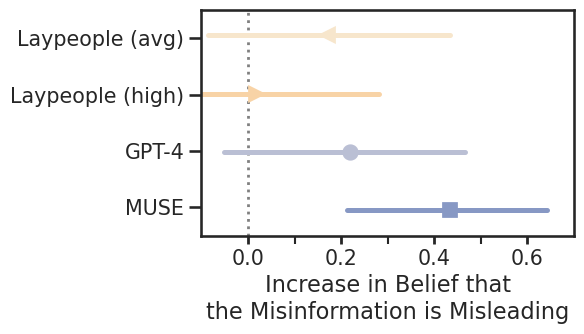

In [39]:
# draw a vertical line at 0
plt.axvline(x=0, color='grey', linestyle='dotted', linewidth=2)

g = sns.pointplot(y='response_type', x='change_in_label', data=pre_post_belief, dodge=True, palette=['#F7E6CC', '#F8D3A6', '#BABFD4', '#8798C4'], markers=['<', '>', 'o', 's'])

ax = g.axes

ax.set_xlabel('Increase in Belief that\nthe Misinformation is Misleading')

ax.set_ylabel('')

# y-ticks 4 to 5: 
ax.set_xlim([-0.1, .7])


ax.set_xticks(np.arange(0., 0.6, 0.1), minor=True)
ax.set_xticks(np.arange(0., 0.61, 0.2), minor=False)


# minor ticks every 0.2, major every 1

# major every 1, minor every 0.2 

# ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
# ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))


# legend outside

# plt.legend(title='Pre Belief', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# increase width

# plt.gcf().set_size_inches(10, 6)
plt.gcf().set_size_inches(6, 3.5)

# tight_layout
plt.tight_layout()

# save

# plt.savefig('plots/change_in_belief.svg')


/tmp/ipykernel_591108/2752079964.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.pointplot(y='condition_map', x='change_in_label', data=pre_post_belief, dodge=True, palette=['#bdbdbd', '#424242'], markers=['x', 'D'],)
/tmp/ipykernel_591108/2752079964.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(0.5, 1.3), loc='upper center', borderaxespad=0., ncol=2, title=None, facecolor='w', edgecolor='w', framealpha=1, fancybox=False, handletextpad=0.2, borderpad=0., labelspacing=0.5, columnspacing=1.)


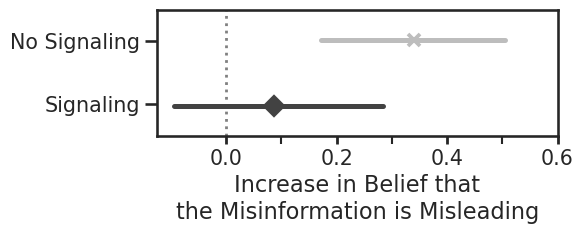

In [41]:
condition_map = {'label': 'Signaling', 'no label': 'No Signaling'}

pre_post_belief['condition_map'] = pre_post_belief['condition_y'].map(condition_map)

pre_post_belief['condition_map'] = pd.Categorical(pre_post_belief['condition_map'], categories=['No Signaling', 'Signaling'], ordered=True)

plt.axvline(x=0, color='grey', linestyle='dotted', linewidth=2)

g = sns.pointplot(y='condition_map', x='change_in_label', data=pre_post_belief, dodge=True, palette=['#bdbdbd', '#424242'], markers=['x', 'D'],)

ax = g.axes

ax.set_xlabel('Increase in Belief that\nthe Misinformation is Misleading')

ax.set_ylabel('')

# y-ticks 4 to 5: 
# ax.set_xlim([-0.1, .6])


ax.set_xticks(np.arange(0., 0.6, 0.1), minor=True)
ax.set_xticks(np.arange(0., 0.61, 0.2), minor=False)


# ax.set_xticklabels(['Before Reading\nthe Response', 'After Reading\nthe Response'])


# legend outside

# plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.legend(bbox_to_anchor=(0.5, 1.3), loc='upper center', borderaxespad=0., ncol=2, title=None, facecolor='w', edgecolor='w', framealpha=1, fancybox=False, handletextpad=0.2, borderpad=0., labelspacing=0.5, columnspacing=1.)


# increase width

plt.gcf().set_size_inches(6, 2.5)

plt.tight_layout()

# save

# plt.savefig('plots/signaling_change_in_belief.svg')



In [42]:
# cohen d

def cohen_d(x, y):
	nx = len(x)
	ny = len(y)
	dof = nx + ny - 2
	return (x.mean() - y.mean()) / ((nx * x.var() + ny * y.var()) / dof)**0.5


# for each response type

for response_type in ['Laypeople (avg)', 'Laypeople (high)', 'GPT-4', 'MUSE']:
	print(response_type)
	print(cohen_d(pre_post_belief_concat[(pre_post_belief_concat['response_type'] == response_type) & ~(pre_post_belief_concat['pre_label'].isna())]['pre_label'], pre_post_belief_concat[(pre_post_belief_concat['response_type'] == response_type) & ~(pre_post_belief_concat['post_label'].isna())]['post_label']))

	print('pre: ', pre_post_belief_concat[pre_post_belief_concat['response_type'] == response_type]['pre_label'].mean())

	print('post: ', pre_post_belief_concat[pre_post_belief_concat['response_type'] == response_type]['post_label'].mean())


	# diff

	print('diff: ', pre_post_belief_concat[pre_post_belief_concat['response_type'] == response_type]['post_label'].mean() - pre_post_belief_concat[pre_post_belief_concat['response_type'] == response_type]['pre_label'].mean())

	# relative_diff

	print('relative_diff: ', (pre_post_belief_concat[pre_post_belief_concat['response_type'] == response_type]['post_label'].mean() - pre_post_belief_concat[pre_post_belief_concat['response_type'] == response_type]['pre_label'].mean()) / pre_post_belief_concat[pre_post_belief_concat['response_type'] == response_type]['pre_label'].mean())

Laypeople (avg)
-0.10598981281777248
pre:  4.264227642276423
post:  4.436734693877551
diff:  0.17250705160112823
relative_diff:  0.040454465866422824
Laypeople (high)
-0.009265442607229451
pre:  4.592741935483871
post:  4.608870967741935
diff:  0.016129032258064058
relative_diff:  0.003511852502194808
GPT-4
-0.12809241255693796
pre:  4.467741935483871
post:  4.69758064516129
diff:  0.22983870967741904
relative_diff:  0.051444043321299565
MUSE
-0.26582026528110736
pre:  4.449799196787149
post:  4.883534136546185
diff:  0.4337349397590362
relative_diff:  0.09747292418772564


In [44]:
# is the difference between pre_label and post_label statistically significant?

from scipy.stats import ttest_ind

# for each response type

for response_type in pre_post_belief_concat['response_type'].unique():
	pre_label_belief = pre_post_belief_concat[(pre_post_belief_concat['response_type'] == response_type) & (~pre_post_belief_concat['pre_label'].isna())]['pre_label']
	post_label_belief = pre_post_belief_concat[(pre_post_belief_concat['response_type'] == response_type) & (~pre_post_belief_concat['post_label'].isna())]['post_label']
	print(response_type)
	
	print('Ttest:', ttest_ind(pre_label_belief, post_label_belief))

	print('Pre Mean:', pre_label_belief.mean())
	print('Post Mean:', post_label_belief.mean())

	# diff
	print('Diff:', post_label_belief.mean() - pre_label_belief.mean())

	# relative diff

	print('Relative Diff:', (post_label_belief.mean() - pre_label_belief.mean()) / pre_label_belief.mean())



Laypeople (avg)
Ttest: TtestResult(statistic=-1.1766853720355486, pvalue=0.23989357050046864, df=489.0)
Pre Mean: 4.264227642276423
Post Mean: 4.436734693877551
Diff: 0.17250705160112823
Relative Diff: 0.040454465866422824
MUSE
Ttest: TtestResult(statistic=-2.9719848821580093, pvalue=0.0031025438591264463, df=496.0)
Pre Mean: 4.449799196787149
Post Mean: 4.883534136546185
Diff: 0.4337349397590362
Relative Diff: 0.09747292418772564
GPT-4
Ttest: TtestResult(statistic=-1.4292612253027335, pvalue=0.1535612105237114, df=494.0)
Pre Mean: 4.467741935483871
Post Mean: 4.69758064516129
Diff: 0.22983870967741904
Relative Diff: 0.051444043321299565
Laypeople (high)
Ttest: TtestResult(statistic=-0.10338424883592877, pvalue=0.9176999686421137, df=494.0)
Pre Mean: 4.592741935483871
Post Mean: 4.608870967741935
Diff: 0.016129032258064058
Relative Diff: 0.003511852502194808


In [45]:
# is the difference between pre_label and post_label statistically significant?

from scipy.stats import ttest_ind

# for each response type

for response_type in pre_post_belief['response_type'].unique():
	change_in_label_belief = pre_post_belief[(pre_post_belief['response_type'] == response_type) & (~pre_post_belief['change_in_label'].isna())]['change_in_label']

	print(response_type)
	
	print('Ttest:', ttest_ind(change_in_label_belief, np.zeros(len(change_in_label_belief))))

Laypeople (avg)
Ttest: TtestResult(statistic=1.3067595527760203, pvalue=0.19190985404850694, df=488.0)
MUSE
Ttest: TtestResult(statistic=3.8465534552269625, pvalue=0.0001354116715502051, df=496.0)
GPT-4
Ttest: TtestResult(statistic=1.780405947543099, pvalue=0.07562654967902947, df=492.0)
Laypeople (high)
Ttest: TtestResult(statistic=0.11751460994863987, pvalue=0.9065000301794334, df=494.0)


In [46]:
# is the difference between pre_label and post_label statistically significant?

from scipy.stats import ttest_ind

# for each response type

for response_type in pre_post_belief['condition_map'].unique():
	change_in_label_belief = pre_post_belief[(pre_post_belief['condition_map'] == response_type) & (~pre_post_belief['change_in_label'].isna())]['change_in_label']

	print(response_type)
	
	print('Ttest:', ttest_ind(change_in_label_belief, np.zeros(len(change_in_label_belief))))

Signaling
Ttest: TtestResult(statistic=0.9642335140367417, pvalue=0.335159214013972, df=1012.0)
No Signaling
Ttest: TtestResult(statistic=3.8484859335068693, pvalue=0.00012669265727446456, df=962.0)


### Intention to Share

In [47]:
pre_intention = pd.read_csv(data_path + 'pre_intention.csv')

In [48]:
# prolific id is not None

pre_intention = pre_intention[pre_intention['prolific_id'].notnull()]

# condition is not None

pre_intention = pre_intention[pre_intention['condition'].notnull()]

In [49]:
# remove duplicate prolific id, keep the last one

pre_intention = pre_intention.drop_duplicates(subset='prolific_id', keep='last')

In [50]:
post_intention = pd.read_csv(data_path + 'post_intention.csv')

In [51]:
post_intention = post_intention.drop_duplicates(subset='prolific_id', keep='last')

In [52]:
# join pre and post belief on prolific id, post id

pre_intention = pre_intention.rename(columns={'label': 'pre_label'})
post_intention = post_intention.rename(columns={'label': 'post_label'})

pre_post_intention = pd.merge(pre_intention, post_intention, on='prolific_id', how='inner')

In [53]:
pre_intention['collection_time'] = 'pre'
post_intention['collection_time'] = 'post'

pre_intention['label'] = pre_intention['pre_label']
post_intention['label'] = post_intention['post_label']

In [55]:
pre_post_intention_concat = pd.concat([pre_intention, post_intention], axis=0)

In [56]:
pre_post_intention_concat = pd.merge(pre_post_intention_concat, posts[['post_id', 'response_type']], on='post_id', how='inner')

In [57]:
pre_post_intention_concat['response_type'] = pre_post_intention_concat['response_type'].map({'human-high': 'Laypeople (high)', 'human-avg': 'Laypeople (avg)', 'gpt-4': 'GPT-4', 'muse': 'MUSE'})

pre_post_intention_concat['response_type'] = pd.Categorical(pre_post_intention_concat['response_type'], categories=['Laypeople (avg)', 'Laypeople (high)', 'GPT-4', 'MUSE'], ordered=True)

In [58]:
pre_post_intention['change_in_label'] = pre_post_intention['pre_label'] - pre_post_intention['post_label']


In [59]:
pre_post_intention = pre_post_intention.rename(columns={'post_id_x': 'post_id'})

pre_post_intention = pd.merge(pre_post_intention, posts[['post_id', 'response_type']], on='post_id', how='inner')

In [60]:
pre_post_intention['response_type'] = pre_post_intention['response_type'].map({'human-high': 'Laypeople (high)', 'human-avg': 'Laypeople (avg)', 'gpt-4': 'GPT-4', 'muse': 'MUSE'})

pre_post_intention['response_type'] = pd.Categorical(pre_post_intention['response_type'], categories=['Laypeople (avg)', 'Laypeople (high)', 'GPT-4', 'MUSE'], ordered=True)

/tmp/ipykernel_591108/2797102275.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.pointplot(y='response_type', x='change_in_label', data=pre_post_intention, dodge=True, palette=['#F7E6CC', '#F8D3A6', '#BABFD4', '#8798C4'], markers=['<', '>', 'o', 's'])


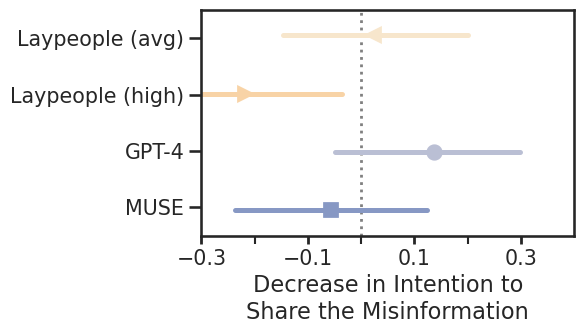

In [61]:
# draw a vertical line at 0
plt.axvline(x=0, color='grey', linestyle='dotted', linewidth=2)

g = sns.pointplot(y='response_type', x='change_in_label', data=pre_post_intention, dodge=True, palette=['#F7E6CC', '#F8D3A6', '#BABFD4', '#8798C4'], markers=['<', '>', 'o', 's'])

ax = g.axes

ax.set_xlabel('Decrease in Intention to\nShare the Misinformation')

ax.set_ylabel('')

# y-ticks 4 to 5: 
ax.set_xlim([-0.3, .4])


ax.set_xticks(np.arange(-0.3, 0.3, 0.1), minor=True)
ax.set_xticks(np.arange(-0.3, 0.31, 0.2), minor=False)


# minor ticks every 0.2, major every 1

# major every 1, minor every 0.2 

# ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
# ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))


# legend outside

# plt.legend(title='Pre Belief', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# increase width
# plt.gcf().set_size_inches(10, 6)
plt.gcf().set_size_inches(6, 3.5)

# tight_layout
plt.tight_layout()
# plt.gcf().set_size_inches(10, 6)

# plt.savefig('plots/change_in_intention_to_share.svg')


/tmp/ipykernel_591108/1709901144.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.pointplot(y='condition_map', x='change_in_label', data=pre_post_intention, dodge=True, palette=['#bdbdbd', '#424242'], markers=['x', 'D'],)
/tmp/ipykernel_591108/1709901144.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(0.5, 1.3), loc='upper center', borderaxespad=0., ncol=2, title=None, facecolor='w', edgecolor='w', framealpha=1, fancybox=False, handletextpad=0.2, borderpad=0., labelspacing=0.5, columnspacing=1.)


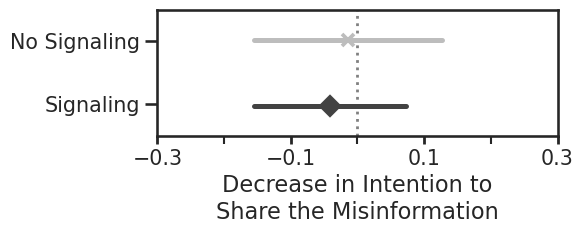

In [62]:
condition_map = {'label': 'Signaling', 'no label': 'No Signaling'}

pre_post_intention['condition_map'] = pre_post_intention['condition_y'].map(condition_map)

pre_post_intention['condition_map'] = pd.Categorical(pre_post_intention['condition_map'], categories=['No Signaling', 'Signaling'], ordered=True)

plt.axvline(x=0, color='grey', linestyle='dotted', linewidth=2)

g = sns.pointplot(y='condition_map', x='change_in_label', data=pre_post_intention, dodge=True, palette=['#bdbdbd', '#424242'], markers=['x', 'D'],)

ax = g.axes

ax.set_xlabel('Decrease in Intention to\nShare the Misinformation')

ax.set_ylabel('')

# y-ticks 4 to 5: 
# ax.set_xlim([-0.3, .4])


ax.set_xticks(np.arange(-0.3, 0.3, 0.1), minor=True)
ax.set_xticks(np.arange(-0.3, 0.31, 0.2), minor=False)



# ax.set_xticklabels(['Before Reading\nthe Response', 'After Reading\nthe Response'])


# legend outside

# plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.legend(bbox_to_anchor=(0.5, 1.3), loc='upper center', borderaxespad=0., ncol=2, title=None, facecolor='w', edgecolor='w', framealpha=1, fancybox=False, handletextpad=0.2, borderpad=0., labelspacing=0.5, columnspacing=1.)


# increase width

plt.gcf().set_size_inches(6, 2.5)

plt.tight_layout()

# save

# plt.savefig('plots/signaling_change_in_intention_to_share.svg')



In [63]:
# is the difference between pre_label and post_label statistically significant?

from scipy.stats import ttest_ind

# for each response type

for response_type in pre_post_intention['response_type'].unique():
	change_in_label_belief = pre_post_intention[(pre_post_intention['response_type'] == response_type) & (~pre_post_intention['change_in_label'].isna())]['change_in_label']

	print(response_type)
	
	print('Ttest:', ttest_ind(change_in_label_belief, np.zeros(len(change_in_label_belief))))

Laypeople (avg)
Ttest: TtestResult(statistic=0.2651799019943445, pvalue=0.7909828533035742, df=488.0)
MUSE
Ttest: TtestResult(statistic=-0.6240840791155338, pvalue=0.5328592925162852, df=496.0)
GPT-4
Ttest: TtestResult(statistic=1.503481925144707, pvalue=0.133353819305295, df=494.0)
Laypeople (high)
Ttest: TtestResult(statistic=-2.272766286707224, pvalue=0.023468988729152426, df=494.0)


### Trustworthiness

In [65]:
trustworthiness = pd.read_csv(data_path + 'trustworthiness.csv')

In [67]:
# prolific id is not None

trustworthiness = trustworthiness[trustworthiness['prolific_id'].notnull()]

# condition is not None

trustworthiness = trustworthiness[trustworthiness['condition'].notnull()]

In [68]:
# remove duplicate prolific id, keep the last one

trustworthiness = trustworthiness.drop_duplicates(subset='prolific_id', keep='last')

In [69]:
trustworthiness = trustworthiness[trustworthiness['prolific_id'] != '62cf2c16297da842a4b56430']

In [70]:
# condition re-label "label" to "Signaling" and "no label" to "No Signaling"

trustworthiness['condition_map'] = trustworthiness['condition'].map({'label': 'Signaling', 'no label': 'No Signaling'})

In [71]:
# merge with posts[['post_id', 'response_type']]

trustworthiness = pd.merge(trustworthiness, posts[['post_id', 'response_type']], on='post_id', how='inner')

In [72]:
# response_type -- Categorical and Ordered 'human-avg', 'human-high', 'gpt-4', 'muse'

# map 'human-high' to 'Laypeople (high)', 'human-avg' to 'Laypeople (avg)', 'gpt-4' to 'GPT-4', 'muse' to 'MUSE'

trustworthiness['response_type'] = trustworthiness['response_type'].map({'human-high': 'Laypeople (high)', 'human-avg': 'Laypeople (avg)', 'gpt-4': 'GPT-4', 'muse': 'MUSE'})

trustworthiness['response_type'] = pd.Categorical(trustworthiness['response_type'], categories=['Laypeople (avg)', 'Laypeople (high)', 'GPT-4', 'MUSE'], ordered=True)

/tmp/ipykernel_591108/1759135894.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.pointplot(y='response_type', x='label', data=trustworthiness, palette=['#F7E6CC', '#F8D3A6', '#BABFD4', '#8798C4'], markers=['<', '>', 'o', 's'])


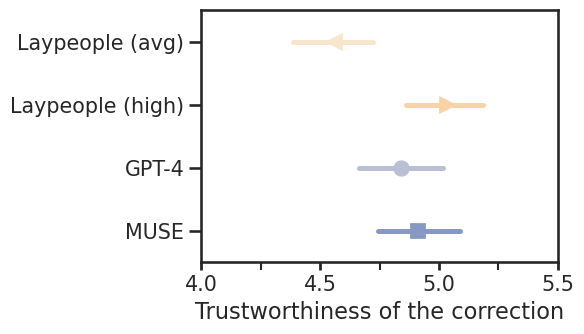

In [73]:
g = sns.pointplot(y='response_type', x='label', data=trustworthiness, palette=['#F7E6CC', '#F8D3A6', '#BABFD4', '#8798C4'], markers=['<', '>', 'o', 's'])

ax = g.axes

# y-ticks 4 to 5: 
ax.set_xlim([4, 5.5])


ax.set_xticks(np.arange(4, 5.41, 0.25), minor=True)
ax.set_xticks(np.arange(4, 5.51, 0.5), minor=False)



ax.set_ylabel('')

ax.set_xlabel('Trustworthiness of the correction')

# plt.gcf().set_size_inches(10, 6)
plt.gcf().set_size_inches(6, 3.5)

# tight_layout
plt.tight_layout()

# plt.savefig('plots/trustworthiness.svg')



/tmp/ipykernel_591108/932105482.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.pointplot(y='condition_map', x='label', data=trustworthiness, dodge=True, palette=['#bdbdbd', '#424242'], markers=['x', 'D'],)
/tmp/ipykernel_591108/932105482.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(0.5, 1.3), loc='upper center', borderaxespad=0., ncol=2, title=None, facecolor='w', edgecolor='w', framealpha=1, fancybox=False, handletextpad=0.2, borderpad=0., labelspacing=0.5, columnspacing=1.)


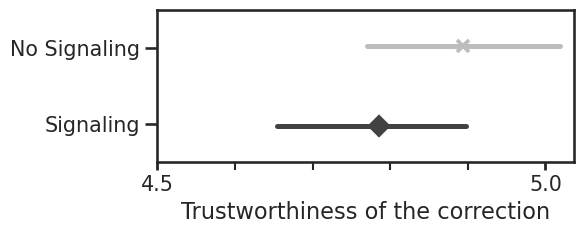

In [74]:
condition_map = {'label': 'Signaling', 'no label': 'No Signaling'}

trustworthiness['condition_map'] = trustworthiness['condition'].map(condition_map)

trustworthiness['condition_map'] = pd.Categorical(trustworthiness['condition_map'], categories=['No Signaling', 'Signaling'], ordered=True)

# plt.axvline(x=0, color='grey', linestyle='dotted', linewidth=2)

# 
g = sns.pointplot(y='condition_map', x='label', data=trustworthiness, dodge=True, palette=['#bdbdbd', '#424242'], markers=['x', 'D'],)

ax = g.axes

ax.set_xlabel('Trustworthiness of the correction')

ax.set_ylabel('')

# y-ticks 4 to 5: 
# ax.set_xlim([-0.3, .4])


ax.set_xticks(np.arange(4.5, 5.01, 0.1), minor=True)
ax.set_xticks(np.arange(4.5, 5.01, 0.5), minor=False)



# ax.set_xticklabels(['Before Reading\nthe Response', 'After Reading\nthe Response'])


# legend outside

# plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.legend(bbox_to_anchor=(0.5, 1.3), loc='upper center', borderaxespad=0., ncol=2, title=None, facecolor='w', edgecolor='w', framealpha=1, fancybox=False, handletextpad=0.2, borderpad=0., labelspacing=0.5, columnspacing=1.)


# increase width

plt.gcf().set_size_inches(6, 2.5)

plt.tight_layout()

# save

# plt.savefig('plots/signaling_trustworthiness.svg')



In [75]:
# groupby 'response_type', mean 'label'

trustworthiness.groupby('response_type')['label'].mean()

/tmp/ipykernel_591108/330026778.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trustworthiness.groupby('response_type')['label'].mean()


response_type
Laypeople (avg)     4.563265
Laypeople (high)    5.032258
GPT-4               4.842105
MUSE                4.911647
Name: label, dtype: float64

In [76]:
# check statistical significance with Laypeople (avg)

from scipy.stats import ttest_ind

trustworthiness_avg = trustworthiness[trustworthiness['response_type'] == 'Laypeople (avg)']

# GPT-4, Laypeople (high), MUSE

for response_type in ['GPT-4', 'Laypeople (high)', 'MUSE']:
	trustworthiness_response = trustworthiness[trustworthiness['response_type'] == response_type]
	print(response_type)
	print(ttest_ind(trustworthiness_avg['label'], trustworthiness_response['label']))
	print('Layepeople (avg) Mean:', trustworthiness_avg['label'].mean())
	print(response_type, 'Mean:', trustworthiness_response['label'].mean())
	print('Diff:', trustworthiness_response['label'].mean() - trustworthiness_avg['label'].mean())
	print('Relative Diff:', (trustworthiness_response['label'].mean() - trustworthiness_avg['label'].mean()) / trustworthiness_avg['label'].mean())

GPT-4
TtestResult(statistic=-2.2361780617799263, pvalue=0.02578946097296746, df=490.0)
Layepeople (avg) Mean: 4.563265306122449
GPT-4 Mean: 4.842105263157895
Diff: 0.27883995703544606
Relative Diff: 0.061105357310987735
Laypeople (high)
TtestResult(statistic=-3.766936206516654, pvalue=0.00018531384460061985, df=491.0)
Layepeople (avg) Mean: 4.563265306122449
Laypeople (high) Mean: 5.032258064516129
Diff: 0.4689927583936804
Relative Diff: 0.10277569392348095
MUSE
TtestResult(statistic=-2.887689552394029, pvalue=0.0040517264133481685, df=492.0)
Layepeople (avg) Mean: 4.563265306122449
MUSE Mean: 4.911646586345381
Diff: 0.3483812802229327
Relative Diff: 0.0763447349325747
